##### Name: Chun Hei Michael CHAN

# Practical session 2 - Introduction to Diffeomorphisms

The goal of this practical session is to implement  Large deformation diffeomorphic metric mapping (LDDMM) in registration problem, on anchors.



**Pytorch**: in this practical session, we introduce the package pytorch (developed by Facebook), which is very useful to compute gradient and has plenty of optimization algorithms. We don't ask you to implement these lines, but the rest of the algorithm, including simple operations.
The change for you is to inquire about functions in pytorch : matmul(),mm() etc. 
Don't worry, most of them are similar to the ones in numpy. 

So why don't we use numpy functions ? Because pytorch has its own objets equivalent to arrays : tensors, and so on has its own functions to apply on tensors.

By the way, if you want to do deep learning later, you will meet again pytorch, surely ! 

In [1]:
import numpy as np
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import torch
import scipy.interpolate as spi
from scipy.io import loadmat
tensor_type = torch.DoubleTensor
from IPython.core.display import HTML
HTML(open("./custom_nb.css", "r").read())


## Functions

In [2]:
def _swap_colums(ar, i, j):
    aux = np.copy(ar[:, i])
    ar[:, i] = np.copy(ar[:, j])
    ar[:, j] = np.copy(aux)
    return np.copy(ar)

def load_landmarks_torch(m_reca=None,m_ref=None):
    if m_reca is None :
        m_reca_out = np.load('./data/PsrcAnchors2.npy').T 
    else :
        m_reca_out = m_reca.copy().T     
    if m_ref is None :
        m_ref_out = np.load('./data/PtarAnchors2.npy').T  
    else :
        m_ref_out = m_ref.copy().T
    return _swap_colums(m_reca_out, 0, 1), _swap_colums(m_ref_out, 0, 1)



def interpolate_image(intensities, deformed_pixels, padding_width=1):
    '''
    This function, given original image in intensities, and positions of registeres pixels in original image, return the final registered image
    ------- 
    intensities : (nr,nc,k)
    deformed_pixels : (nr*nc,d)
    -------
    returns registered image in JregLD, of shape (nr,nc,k)
    
    '''
    nr,nc,_ = intensities.shape
    xim,yim = np.meshgrid(range(0,nc),range(0,nr))
    xim = xim.reshape(-1)
    yim = yim.reshape(-1)
    
    deformated_pixels_numpy = deformed_pixels.detach().numpy()

    
    pad = np.ones(intensities.shape)
    padded_image = np.concatenate((np.concatenate([pad,pad,pad],axis=1),np.concatenate([pad,intensities.numpy(),pad],axis=1),np.concatenate([pad,pad,pad],axis=1)),axis=0)

    
    JregLD = np.zeros((nr,nc,3))
    
    for i in range(len(xim)):
        value = padded_image[int(round(deformated_pixels_numpy[i,0]) + nr), int(round(deformated_pixels_numpy[i,1]) + nc),:]
        JregLD[yim[i],xim[i],:] = value

    return JregLD

## Import images

The guideline for this practical session will be anchors : 
-  $I_{ref}$ : the red anchor, is the reference ( or target) image 
-  $I_{reca}$  : the grey anchor, is the picture to register


Here landmarks are already provided, in a .npy object.


In [3]:
Iref = np.array(mpimg.imread("./Images/image_redanch.jpg"))  / 255.
Ireca =  np.array(mpimg.imread("./Images/image_greyanch.jpg")) / 255.

# Output Image - padding
Iref = np.concatenate((Iref,np.ones((45,300,3),dtype=np.int8)),axis=0)


In [4]:
# one-padding to avoid out-of-bounds problems when one do interpolation
nr,nc,_ = Ireca.shape
pad = np.ones((nr,nc,3),dtype=np.int8);
Iref = np.concatenate((np.concatenate([pad,pad,pad],axis=1),np.concatenate([pad,Iref,pad],axis=1),np.concatenate([pad,pad,pad],axis=1)),axis=0)
Ireca = np.concatenate((np.concatenate([pad,pad,pad],axis=1),np.concatenate([pad,Ireca,pad],axis=1),np.concatenate([pad,pad,pad],axis=1)),axis=0)

# positions of "utils pixels"
rutil = np.arange(nr,(2*nr))
cutil = np.arange(nc,(2*nc))



### Original images

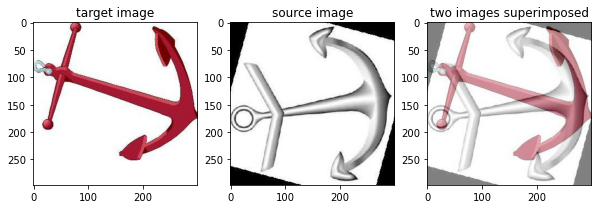

In [5]:
# display original images
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(Iref[:,cutil,:][rutil])
plt.title('target image')
plt.subplot(1,3,2)
plt.imshow(Ireca[:,cutil,:][rutil])
plt.title('source image')
plt.subplot(1,3,3)
plt.imshow(Iref[:,cutil,:][rutil])
plt.imshow(Ireca[:,cutil,:][rutil],alpha=0.5)
plt.title('two images superimposed')
plt.show()

## Import landmarks
Here we import a big set of landmarks, the same as in the first practical session, with 129 points.
You can do the overconstrained affine registration before to compute LDDMM (as in first practical session). 
It will allow faster LDDMM registration. 

We also encourage you to try without "pre-registration".



In [6]:
# Preca2 and Pref2 are reference points in each picture : Preca2 for image to register (grey anchor) and Pref2 for target image (red anchor).

Preca2 = np.load('./data/PsrcAnchors2.npy') 
Pref2 = np.load('./data/PtarAnchors2.npy')
n_landmarks = Preca2.shape[1]

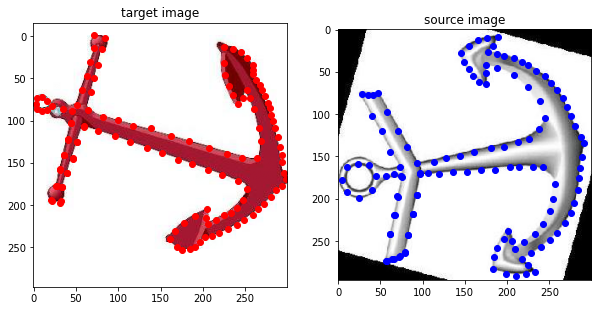

In [7]:
plt.figure(1,figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(Iref[:,cutil,:][rutil])
plt.plot(Pref2[0,:],Pref2[1,:],'or')
plt.title('target image')
plt.subplot(1,2,2)
plt.imshow(Ireca[:,cutil,:][rutil])
plt.plot(Preca2[0,:],Preca2[1,:],'ob')
plt.title('source image')
plt.show()

Text(0.5, 1.0, 'source image')

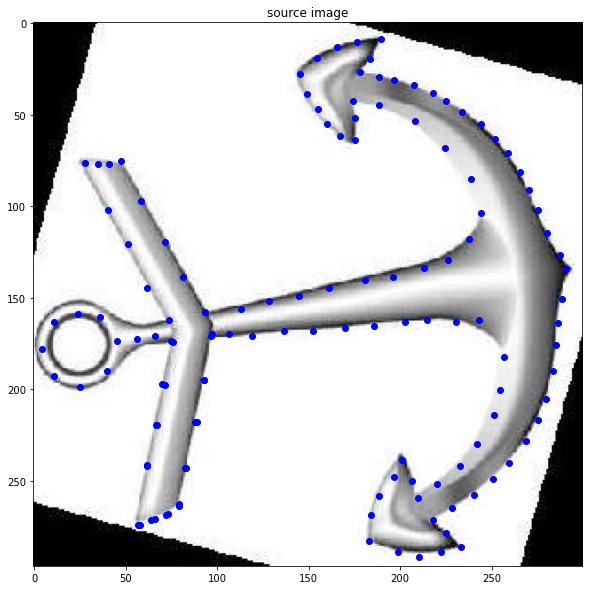

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(Ireca[:,cutil,:][rutil])
plt.plot(Preca2[0,:],Preca2[1,:],'ob');
plt.title('source image')


## Affine registration

This part is identical to overconstrained affine registration from first practical session.  You will obtain the regularized image,  named **Jreg** and registered control points **Preg** and **Preg2**. In the LDDMM algorithm, you will use **Preg2**.



In [9]:
### Load small set of landmarks for affine registration (16 points)
# Preca and Pref are reference points in each picture : Preca for image to register (grey anchor) and Pref for target image (red anchor).

Preca = np.load('./data/PsrcAnchors.npy') 
Pref = np.load('./data/PtarAnchors.npy') 
PtsInd = np.arange(0,n_landmarks)
Npts = np.size(Preca,1)


mPreca = np.mean(Preca,1)
mPref = np.mean(Pref,1)
Preca_copy = Preca - np.repeat(mPreca.reshape(2,-1),Npts,axis=1)
Pref_copy = Pref - np.repeat(mPref.reshape(2,-1),Npts,axis=1)

A = Pref_copy.dot(Preca_copy.T).dot(np.linalg.inv(Preca_copy.dot(Preca_copy.T)))
b = mPref - A.dot(mPreca)


############################
#####  We build a grid with coordinates of original pixels in registered image image
xim,yim = np.meshgrid(np.arange(0,nc),np.arange(0,nr))
xim = xim.reshape(1,-1)
yim = yim.reshape(1,-1)

gridRegInv = np.linalg.inv(A).dot(np.concatenate([xim,yim],axis=0) - np.repeat(b.reshape(2,1),[xim.shape[1]],axis=1))

##################
# Registered image obtained by inversed transformation

Jreg = np.zeros((nr,nc,3))
for i in range(xim.shape[1]):
    value = Ireca[int(round(gridRegInv[1,i]) + nr), int(round(gridRegInv[0,i]) + nc),:]
    Jreg[yim[:,i],xim[:,i],:] = value

Jreg = Jreg


###################################
##### Affine transformation of new landmarks with parameters from first set of landmarks
Preg = A.dot(Preca) + np.repeat(b.reshape(2,1),Npts,axis=1)
Preg2 = A.dot(Preca2) + np.repeat(b.reshape(2,1),n_landmarks,axis=1)


########################
#Affine transformation of source image (grey anchor) - padding
JregA =  np.concatenate((np.concatenate([pad,pad,pad],axis=1),np.concatenate([pad,Jreg,pad],axis=1),np.concatenate([pad,pad,pad],axis=1)),axis=0)/255


Check that the affine registration worked.

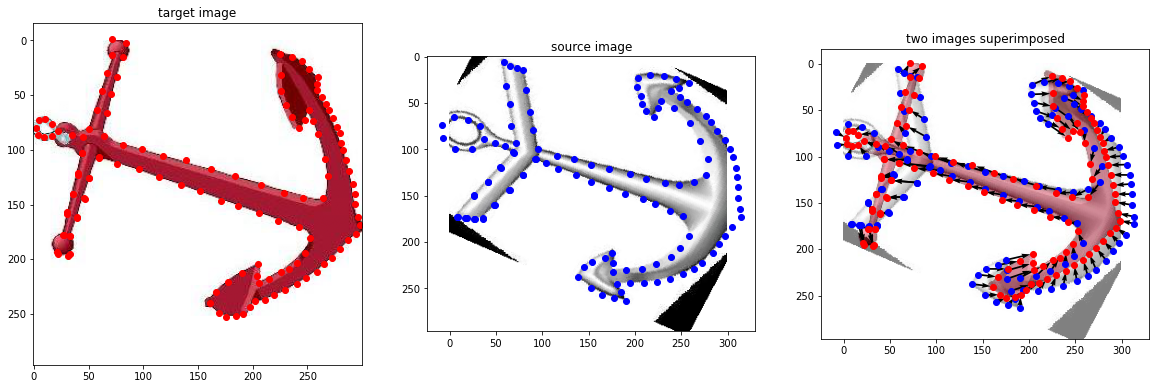

In [10]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(Iref[:,cutil,:][rutil]);
plt.plot(Pref2[0,PtsInd],Pref2[1,PtsInd],'or')
plt.title('target image');

plt.subplot(1,3,2)
plt.imshow(Jreg)
plt.plot(Preg2[0,PtsInd],Preg2[1,PtsInd],'ob');
plt.title('source image')

plt.subplot(1,3,3)
plt.imshow(Iref[:,cutil,:][rutil])
plt.imshow(Jreg,alpha=0.5)
plt.plot(Preg2[0,PtsInd],Preg2[1,PtsInd],'ob');
plt.plot(Pref2[0,PtsInd],Pref2[1,PtsInd],'or');
plt.quiver(Preg2[0,PtsInd],Preg2[1,PtsInd],Pref2[0,PtsInd]-Preg2[0,PtsInd],Pref2[1,PtsInd]-Preg2[1,PtsInd],scale=400,angles='xy');

plt.title('two images superimposed')

plt.show()


## LDDMM functions

In [11]:
def plot_large_deformation_grid(traj_cp, traj_alpha, image, kernel_width,ax):
    '''
    Returns a grid of the deformation field computed with traj_cp and traj_alpha lists.
    -----
    traj_cp : list of length equals to the number of steps of the algorithm (n_step)
    traj_alpha : list of length equals to the number of steps of the algorithm (n_step)
    image : (nr,nc,k)
    '''
    i,j,_ = image.shape
    downsampling_factor = 10
    i_ = i // downsampling_factor
    j_ = j // downsampling_factor
    
    points = np.array(np.meshgrid(range(i_), range(j_))) * downsampling_factor
    points = np.swapaxes(points, 0, 2).reshape(i_ * j_, 2)
    points = torch.from_numpy(points).type(tensor_type)
    deformed_points = register_points(traj_cp, traj_alpha, points, kernel_width)[-1]
    
    g = deformed_points.detach().numpy().reshape(i_, j_, 2)
    ax.plot([g[:, :-1, 1].ravel(), g[:, 1:, 1].ravel()],
            [g[:, :-1, 0].ravel(), g[:, 1:, 0].ravel()], 'k', linewidth=1.2, marker='o', markersize=0.2)
    ax.plot([g[:-1, :, 1].ravel(), g[1:, :, 1].ravel()],
            [g[:-1, :, 0].ravel(), g[1:, :, 0].ravel()], 'k', linewidth=1.2, marker='o', markersize=0.2)


In [12]:
def _differences(x, y):
    """ 
    x is of shape (n, 2)
    y is of shape (m, 2)
    --------
    returns the difference between each element of x and y in a (2,n,m) tensor
    
    """
    x_col = x.t().unsqueeze(2)  # (n,2) -> (2,n,1)
    y_lin = y.t().unsqueeze(1)  # (m,2) -> (2,1,m)
    return x_col - y_lin

def _squared_distances(x, y):
    """ 
    x is of shape (n, 2)
    y is of shape (m, 2)
    
    --------
    returns the squared euclidean distance between each element of x and y in a (n,m) tensor
    
    """
    
    x_norm = (x ** 2).sum(1).view(-1, 1)
    y_norm = (y ** 2).sum(1).view(1, -1)

    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(y, 0, 1))
    
    return dist

def gaussian_kernel(x, y, kernel_width):
    """ 
    x is of shape (n, 2)
    y is of shape (m, 2)
    kernel_width is a value
    
    --------
    returns the gaussian kernel value between each element of x and y in a (n,m) tensor
    
    """
    squared_dist = _squared_distances(x, y)
    return torch.exp(- squared_dist / kernel_width **2 )


def h_gradx(cp, alpha, kernel_width):
    '''
    This function computes derivative of the kernel for each couple (cp_i,alpha_i), with cp_i a control point(landmark).
    ---------
    
    cp is of shape (n_landmarks, 2)
    alpha is of shape (n_landmarks, 2)
    kernel_width is a value
    
    --------
    returns a tensor of shape (n_landmarks, 2)
    '''
    sq = _squared_distances(cp, cp)
    A = torch.exp(-sq / kernel_width **2)
    B = _differences(cp, cp) * A

    return (- 2 * torch.sum(alpha * (torch.matmul(B, alpha)), 2) / (kernel_width ** 2)).t()
    
def discretisation_step(cp, alpha, dt, kernel_width):
    
    '''
    TO DO
    ---------
    This function computes a step of discretized equations for both alpha and control points on one step. 
    Compute here a displacement step  of control points an alpha, from discretized system seen in class.
    ---------
    
    cp is of shape (n_landmarks, 2)
    alpha is of shape (n_landmarks, 2)
    dt is your time step 
    kernel_width is a value
    
    --------
    
    returns resulting control point and alpha displacements in tensors of size (n_landmarks,2)
    
    '''
    
    #We compute the kernel distances stored in A
    sq = _squared_distances(cp, cp)
    A = torch.exp(-sq / kernel_width **2)
    #Update landpoints
    result_cp = cp + dt*torch.matmul(A,alpha)
    
    #we add the grad of hamiltonian therefore it is coherent with lecture note and not just kernel
    result_alpha = alpha + dt*h_gradx(cp,alpha,kernel_width)
        
    return result_cp, result_alpha



def shoot(cp, alpha, kernel_width, n_steps=10):
    
    """
    TO DO
    ------------
    This is the trajectory of a Hamiltonian dynamic, with system seen in lecture notes. 
    Compute here trajectories of control points and alpha from t=0 to t=1.
    ------------
    cp is of shape (n_landmarks, 2)
    alpha is of shape (n_landmarks, 2)
    n_step : number of steps in your hamiltonian trajectory, use to define your time step
    kernel_width is a value
    --------
    returns traj_cp and traj_alpha trajectories of control points and alpha in lists. 
    The length of a list is equal to n_step. 
    In each element of the list, you have a tensor of size (n_landmarks,2) returned by rk2_step_with_dp() function.
    
    
    """
    dt = 1/n_steps
    traj_cp = [cp]
    traj_alpha = [alpha]

    #We pay attention to traj_cp and traj_alpha to have the same length n_steps
    for i in range(1,n_steps):
        cp, alpha = traj_cp[-1], traj_alpha[-1]
        result_cp,result_alpha = discretisation_step(cp,alpha,dt,kernel_width)
        traj_cp.append(result_cp); traj_alpha.append(result_alpha)

    return traj_cp, traj_alpha

In [13]:
def register_points(traj_cp, traj_alpha, y, kernel_width):
    """
    TO DO
    ------------
    This is the application of the computed trajectories on a set of points (landmarks or new points).
    ------------
    
    traj_cp is the list containing the trajectory of your landmarks 
    traj_alpha is is the list containing the trajectory of your alpha 
    y : points you want to register (landmarks or other points), size (n,2)
    kernel_width is a value
    
    --------
    
    returns traj_y,  the trajectory of points y, in a list of lenght n_step. 
    In each element of the list, you should have an array of dimension (n,2) (same dimensions as y)
    
    
    """
    traj_y = [y]
    
    for i in range(0,len(traj_cp)):

        sq = _squared_distances(traj_cp[i], traj_y[-1])
        A = torch.exp(-sq / kernel_width **2)
        y_new = traj_y[-1] + torch.matmul(A.T,traj_alpha[i])
        traj_y.append(y_new)

    #we keep the length of traj_y and traj_cp to be the same
    return traj_y[:-1]

In [50]:
def register_image(traj_cp, traj_alpha, image, kernel_width):
    """
    TO DO
    ------------
    This is the application of the computed trajectories on an image, by computation of inversed phi_1.
    ATTENTION : Compute inverse deformation of image points in a tensor named deformed_points, by using registered_points() function

    ------------
    
    traj_cp is the list containing the trajectory of your landmarks 
    traj_alpha is the list containing the trajectory of your alpha 
    image : image to register, of size (nr,nc,k), k is number of channels/ pixels' values, 3 for colored image, one for grey image
    kernel_width is a value
    
    --------
    
    returns the registered image, of same dimensions as image, (nr,nc,k)
    
    """
    
    #Meshgrid to apply inverse map onto
    xim,yim = np.meshgrid(range(image.shape[1]),range(image.shape[0]))
    xim = xim.reshape(1,-1)
    yim = yim.reshape(1,-1)
    pts = np.stack((yim.reshape(yim.shape[1]),xim.reshape(xim.shape[1]))).T
    pts = torch.from_numpy(pts).type(tensor_type)
    
    #compute inverse map on all the pixels so we can then use interpolate_image to compute registered images
    deformed_points = register_points(traj_cp[::-1], [-alpha for alpha in traj_alpha[::-1]], pts, kernel_width)[-1]
    
    #deformed_points should be of size (nr*nc,d), the image is of size (nr,nc,k)
    return interpolate_image(image, deformed_points)

## LDDMM Algorithm 

In [51]:
def LDDMM(Ireca,Iref,landmarks_reca,landmarks_ref,niter,kernel_width,gamma,eps):
    
    '''
    This is the principal function, which computes gradient descent to minimize error and find optimal trajectories for control points, alpha.
    ------
    Ireca : image to register, in 3 dimensions, of size (nr,nc,k)
    Iref : image of reference (red anchor), that you want to reach, of size (nr,nc,k)
    landmarks_reca : array of size (n_landmarks,2)
    landmarks_ref : array of size (n_landmarks,2)
    niter: number of iterations of the algorithm to optimize trajectories
    kernel_width : value
    gamma : value
    eps : coefficient in step of gradient descent
    ------
    returns the registered image, registered landmarks, and also optimized control points and alpha trajectories

    '''
    
    cp = torch.from_numpy(landmarks_reca).type(tensor_type)
    cp_ref = torch.from_numpy(landmarks_ref).type(tensor_type)
    Im_reca = torch.from_numpy(Ireca.copy()).type(tensor_type)
    Im_ref = torch.from_numpy(Iref).type(tensor_type)
    
    alpha = torch.zeros(cp.size()).type(tensor_type)
    alpha.requires_grad_(True)

    for it in range(niter):
        
        #### Compute an estimation of control points and alpha trajectories
        traj_cp, traj_alpha = shoot(cp, alpha, kernel_width, n_steps=10)
        
        ##### Registration of the landmarks
        deformed_points = register_points(traj_cp, traj_alpha, cp, kernel_width)[-1]
        
        ##### Computation of the error, function to minimize
        error = torch.sum((deformed_points.contiguous().view(-1) - cp_ref.contiguous().view(-1)) ** 2) + gamma * torch.sum(torch.mm(alpha.T,torch.mm(gaussian_kernel(cp,cp,kernel_width), alpha)))
        error.backward()
        
        ### Gradient descent
        eps_mom = eps/np.sqrt(np.sum(alpha.grad.numpy() ** 2))
        with torch.no_grad():
            alpha -=  eps_mom * alpha.grad  
        alpha.grad.zero_()

    #### Inversed of phi to register Im_reca
    registered_image = register_image(traj_cp, traj_alpha, Im_reca, kernel_width) 
    registered_cp = deformed_points.detach().numpy()
    
    

    return registered_image,registered_cp,traj_cp,traj_alpha

## Execution

**Execute here your LDDMM algorithm.**

The cells are already filled. You can modify parameters gamma and kernel_width.  But the parameter eps, adjusting the gradient descent should not be modified.


If you think that the niter number is not enough high to reach good results, you can increase it of course. 

In [67]:
## This function is here to transform control points.
## After application of this function, the shape of control points is (n_landmarks,d).
## !!!!!! This time, in cp_reca and cp_ref : first column corresponds to y-axis, second column to x-axis, to correspond to images dimensions.
cp_reca,cp_ref = load_landmarks_torch(m_reca=Preg2,m_ref=Pref2)


eps = 1 ## Don't play  with this parameter

#########################
#### Play with parameters

kernel_width = 20
gamma = 0
niter = 500


### Jreg is the grey anchor registered with affine registration (as in first practical session). 

Im_reg,Cp_reg,traj_cp,traj_alpha = LDDMM(Jreg,Iref[:,cutil,:][rutil],cp_reca,cp_ref,niter,kernel_width,gamma,eps)

The cell below gives resulting plots of the registered grey anchor, the red anchor, and the deformation field as a grid.

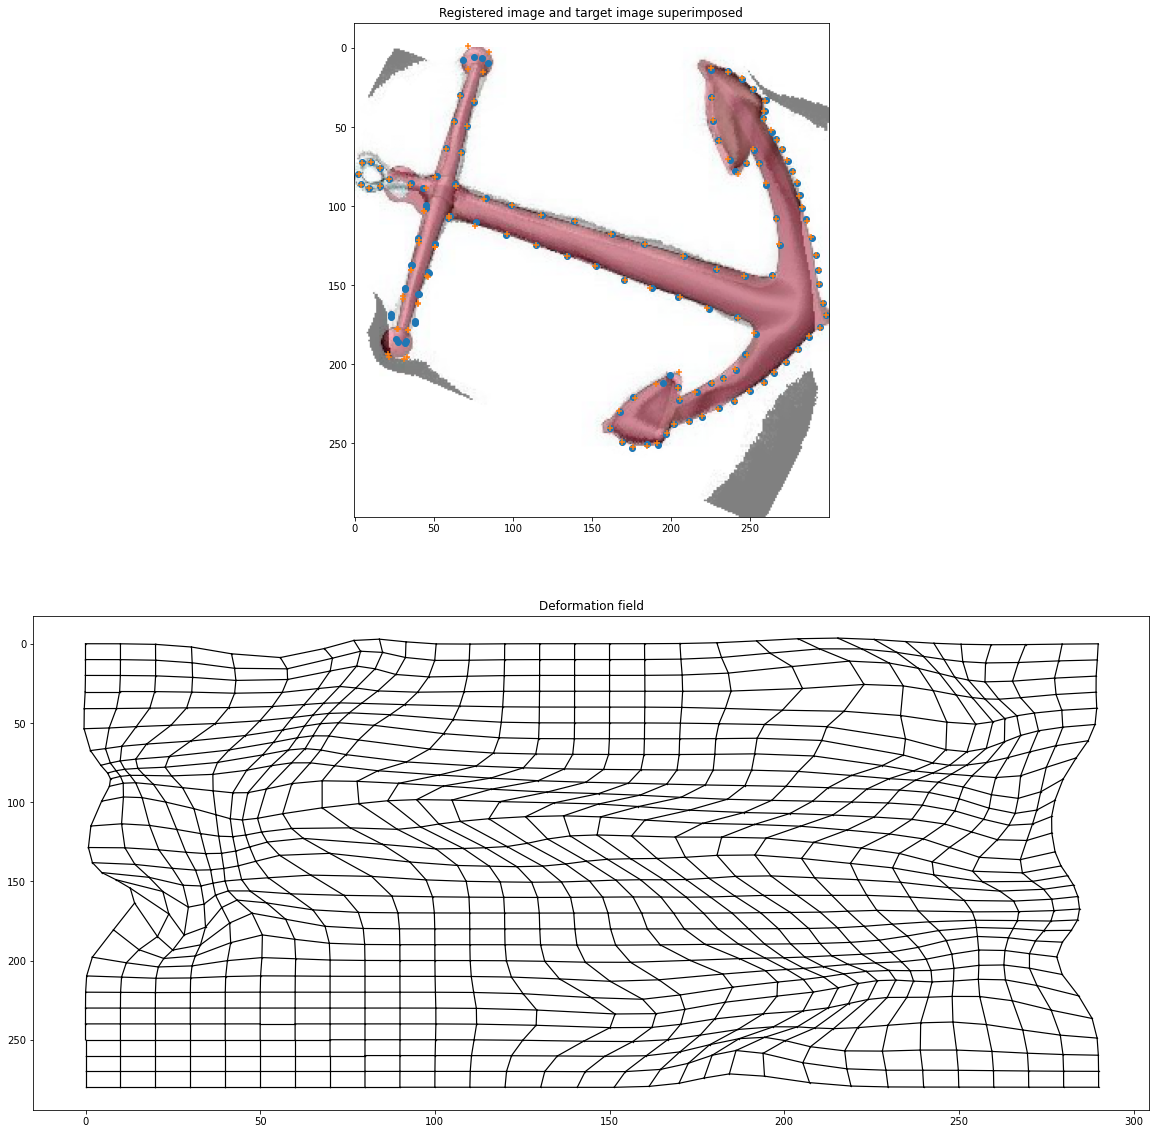

In [68]:
fig = plt.figure(figsize=(20,20))
axes = fig.add_subplot(2, 1, 1)   
axes.imshow(Iref[:,cutil,:][rutil],alpha=1)
axes.imshow(Im_reg,alpha=0.5)
plt.scatter(Cp_reg[:, 1], Cp_reg[:, 0], marker='o')
plt.scatter(Pref2[0,:], Pref2[1,:], marker='+')
plt.title('Registered image and target image superimposed')

axes = fig.add_subplot(2, 1, 2)
plot_large_deformation_grid(traj_cp, traj_alpha, Jreg, kernel_width,axes)
fig.gca().invert_yaxis()
plt.title('Deformation field')
plt.show()

**Play with the different parameters**

**Q: What do the parameters gamma and kernel_width correspond to?**



##### Answer:
Gamma and kernel_width is homologeous to the gamma and the sigma in the previous non-linear registration method. When it comes to the effect of the two parameters, we can notice the following:
- gamma is small: (or even 0), the registered image is fitting well the target image, the target landmarks are reached and thus the two images are overlapping fine
- gamma is large: the registered image is not fitting well the target image, the two images are not overlapping well (too much penalty)
- kernel_width is small: the movements are local, only the neigbourhood of the landmarks path are affected by shifting, we also notice possibility of overlap since some points can be not shifted due to locality of kernel, other points highly shifted since they are close to the landmarks path
- kernel_width is large: the movements are more global, and therefore, opposed to when the kernel_width being small, we have no overlapping of points in the registered image